Our first experiment is the diffusion model for a $\delta$ function target distribution. But let us prepare some other distributions as well.

In [ ]:
# Initial data set 
import torch.distributions as D

def data_Gaussian_p0(N_samples,mu,sigma,dim=2):
    return torch.normal(mu, sigma, size=(N_samples, dim)).to(device)

def data_delta_p0(N_samples,z_0,dim=2):
    return torch.tensor(z_0).expand(N_samples, dim).to(device)

def sample_gaussian_mixture_2d(N_samples, n_modes=5, std=1.0, scale=10.0, x_offset=0.0, seed=123, symmetric=True):
    torch.manual_seed(seed)
    
    # Generate means
    if symmetric:
        angles = torch.linspace(0, 2 * torch.pi, n_modes + 1)[:-1]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale
    else:
        means = (torch.rand(n_modes, 2) - 0.5) * scale
    means += torch.tensor([x_offset, 0.0])
    
    # Generate covariances and weights
    covs = torch.eye(2).repeat(n_modes, 1, 1) * std ** 2
    weights = torch.ones(n_modes) / n_modes
    
    # Create mixture distribution
    dist = D.MixtureSameFamily(
        mixture_distribution=D.Categorical(probs=weights),
        component_distribution=D.MultivariateNormal(
            loc=means,
            covariance_matrix=covs
        )
    )
    
    # Sample
    return dist.sample((N_samples,))

By convention, I want the target distribution to be defined at $t=0$, while the noise is defined at $t=1$. For the forward process, we have,
\begin{equation}
d X_t = u_t(X_t|z)dt + \sigma\, dW_t, \quad \quad X_0 = z \sim p_0 \notag
\end{equation}
where $X_0$ is the initial condition and the target distribution is $p_0=\delta(z)$ as our first example. Now we know the probability distribution that satisfy this equation is the Fokker-Planck equation. 

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim.adam


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ForwardSDE(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim

    def alpha(self, t):
        return 1 - t  

    def beta(self, t):
        return torch.sqrt(t)

    # Forward process: adds noise to data
    def forward_step(self, x0, t):
        alpha_t = self.alpha(t)  # (bs, 1)
        beta_t = self.beta(t)    # (bs, 1)
        noise = torch.randn_like(x0).to(device)
        x_t = alpha_t * x0 + beta_t * noise
        return x_t

    def score(self, x0, t):
        x_t = self.forward_step(x0, t)
        return -(x_t - self.alpha(t) * x0) / (self.beta(t)**2+1e-5 ) 

    def sample_xt(self, x0, t):
        return self.forward_step(x0, t)
    

class ApproxScore(nn.Module):
    def __init__(self, dim=2, hiddens=[64, 64, 64, 64]):
        super().__init__()
        layers = []
        dims = [dim + 1] + hiddens + [dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.SiLU())
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=-1)
        return self.net(xt)

class Trainer(nn.Module):
    def __init__(self, sde, score_model):
        super().__init__()
        self.sde = sde
        self.score_model = score_model
        self.target_score=sde.score
        self.trained_score=None

    def get_train_loss(self, x_0):
        batch_size = x_0.shape[0]
        t = torch.rand(batch_size, 1).to(device)  # (bs, 1)
        x_t = self.sde.sample_xt(x_0, t)  # (bs, dim)
        pred_score = self.score_model(x_t, t)  # (bs, dim)
        true_score = self.sde.score(x_0, t)  # (bs, dim)
        return torch.abs(pred_score - true_score).mean()

    def train(self, x_0, num_epochs, lr):
        self.score_model.to(device)
        optimizer = torch.optim.Adam(self.score_model.parameters(), lr=lr)
        self.score_model.train()
        for epoch in tqdm(range(num_epochs), desc="Training"):
            optimizer.zero_grad()
            loss = self.get_train_loss(x_0)
            loss.backward()
            optimizer.step()
            #print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
        self.score_model.eval()   
        self.trained_score = self.score_model

# Sample from the learned score using time reversed SDE
def BackwardProcess(score_model, num_samples=1000, num_timesteps=300, sigma=1.0, dim=2):
    """Backward process: Sample using reverse SDE with learned score"""
    x_t = torch.randn(num_samples, dim).to(device)  # Start from noise
    ts = torch.linspace(1.0, 0.0, num_timesteps + 1).to(device)
    dt = -1.0 / num_timesteps
    for t in ts[:-1]:
        t = t.view(1, 1).expand(num_samples, 1)
        score = score_model(x_t, t)
        drift = (x_t / (1 - t + 1e-5)) + score # Reverse SDE drift
        noise = sigma * torch.randn_like(x_t) * (-dt)**0.5
        x_t = x_t + drift * dt + noise
    return x_t         



In [ ]:


def sample_inspection(samples, title, bounds=(-15, 15), ax=None, xlabel='x', ylabel='y'):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    samples = samples.detach().cpu().numpy()
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

def density_inspection(samples, title, bounds=(-15, 15), ax=None,xlabel='x', ylabel='y'):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    samples = samples.detach().cpu().numpy()
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=ax, cmap="Blues", fill=True)
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

def plot_forward_process(sde, x_0, timesteps=[0.0, 0.3, 0.6, 1.0], bounds=(-15, 15)):
   
    fig, axes = plt.subplots(1, len(timesteps), figsize=(4 * len(timesteps), 4))
    if len(timesteps) == 1:
        axes = [axes]
    for i, t in enumerate(timesteps):
        t_tensor=torch.tensor([t]).view(1, 1).expand(x_0.shape[0], 1).to(x_0.device)
        x_t = sde.sample_xt(x_0,t_tensor)
        sample_inspection(x_t, title=f"Forward Process (t={t:.1f})", bounds=bounds, ax=axes[i])
    plt.tight_layout()
    return fig


def plot_backward_process(score_model, num_samples=1000, timesteps=[1.0, 0.6, 0.3, 0.0], num_timesteps=1000, sigma=1.0, dim=2, bounds=(-15, 15)):
    # define figure properties and data sturcture
    fig, axes = plt.subplots(1, len(timesteps), figsize=(4 * len(timesteps), 4))
    if len(timesteps) == 1:
        axes = [axes]
    x_t = torch.randn(num_samples, dim).to(score_model.net[0].weight.device)  # Start from noise
    ts = torch.linspace(1.0, 0.0, num_timesteps + 1).to(x_t.device)
    dt = -1.0 / num_timesteps
    timestep_indices = [int((1.0 - t) * num_timesteps) for t in timesteps]
    saved_samples = []
    for i, t in enumerate(ts):
        t = t.view(1, 1).expand(num_samples, 1)
        score = score_model(x_t, t)

        drift = (x_t / (1 - t + 1e-5)) + score  # Add small epsilon to avoid division by zero at t=1
        #noise = torch.randn_like(x_t) * (-dt)**0.5
        #drift = -0.5 * sigma**2 * score
        noise = sigma * torch.randn_like(x_t) * (-dt)**0.5
        x_t = x_t + drift * dt + noise
        if i in timestep_indices:
            saved_samples.append(x_t.clone())
    for i, (t, samples) in enumerate(zip(timesteps, saved_samples)):
        sample_inspection(samples, title=f"Backward Process (t={t:.1f})", bounds=bounds, ax=axes[i])
    plt.tight_layout()
    return fig

In [3]:
test_data=data_delta_p0(N_samples=500,z_0=[1,1],dim=2)
test_data=test_data.to(dtype=torch.float32)

torch.Size([500, 2])


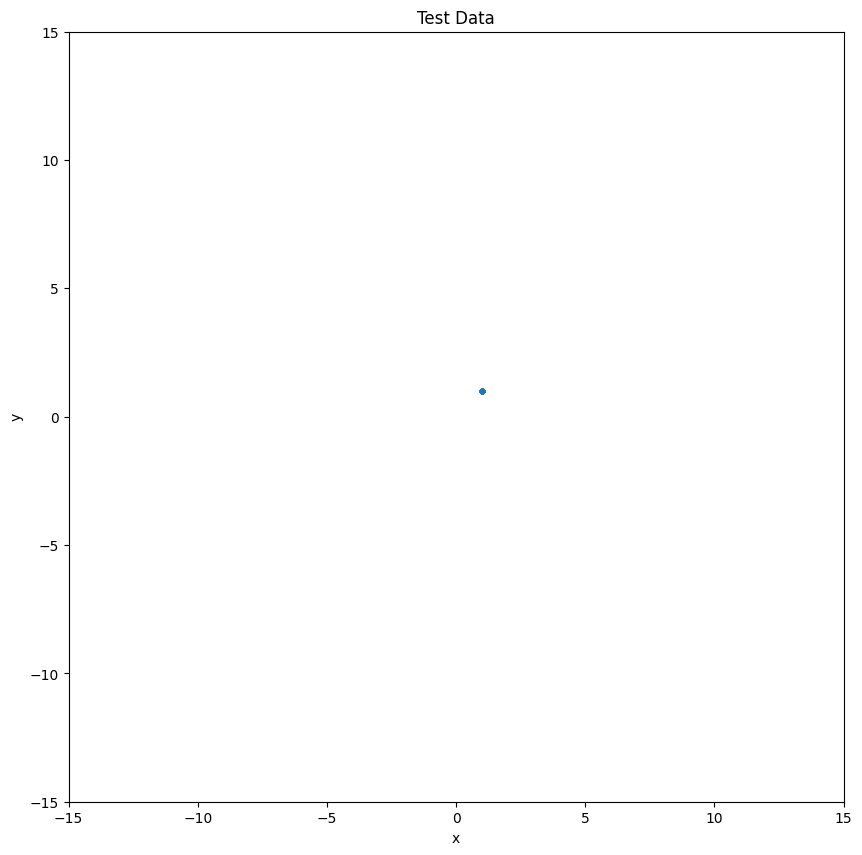

In [4]:
import matplotlib.pyplot as plt
import visualization as vis
print(test_data.size())
fig,ax=plt.subplots(figsize=(10,10))
vis.sample_inspection(test_data, ax=ax, title="Test Data", xlabel='x', ylabel='y')
plt.show()

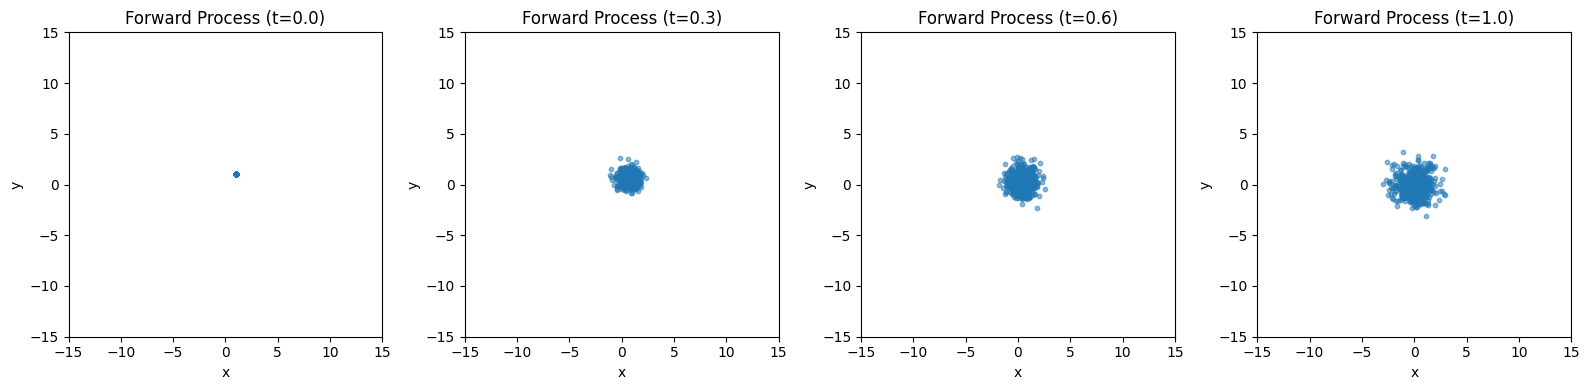

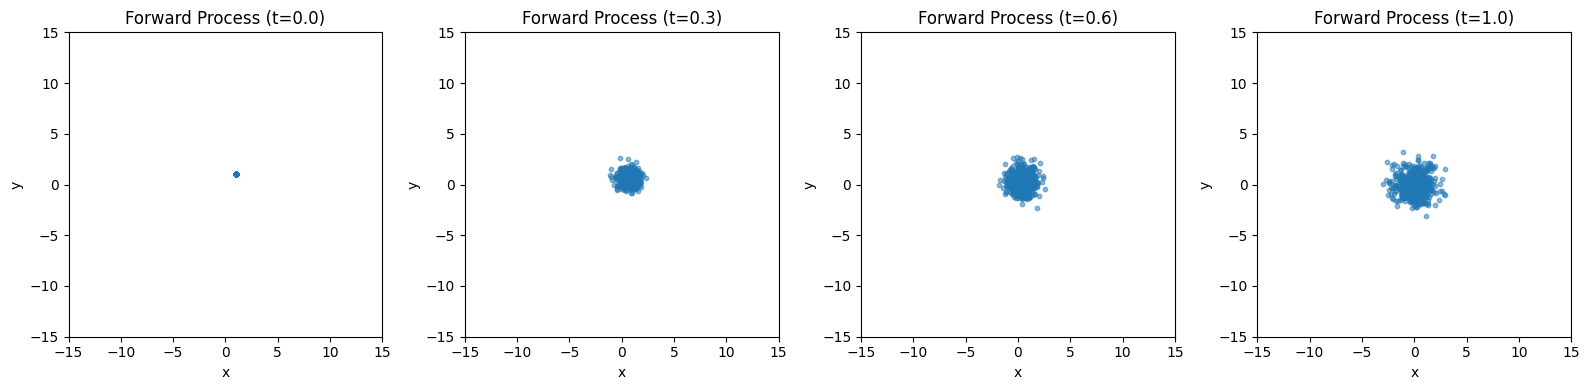

In [5]:
forward_model=ForwardSDE(dim=2)
vis.plot_forward_process(forward_model,test_data,timesteps=[0.0, 0.3, 0.6, 1.0],bounds=(-15, 15))
# Test_trainer=Trainer(ForwardSDE, ApproxScore(dim=2, hiddens=[64, 64, 64, 64]))

In [6]:
# define the trainer
trainer = Trainer(sde=forward_model, score_model=ApproxScore(dim=2, hiddens=[64, 64, 64, 64]))

In [7]:
trainer.train(x_0=test_data, num_epochs=10000, lr=1e-3)

Training: 100%|██████████| 10000/10000 [00:06<00:00, 1444.21it/s]


In [19]:
print(f"score_model type: {type(trainer.score_model)}")

score_model type: <class '__main__.ApproxScore'>


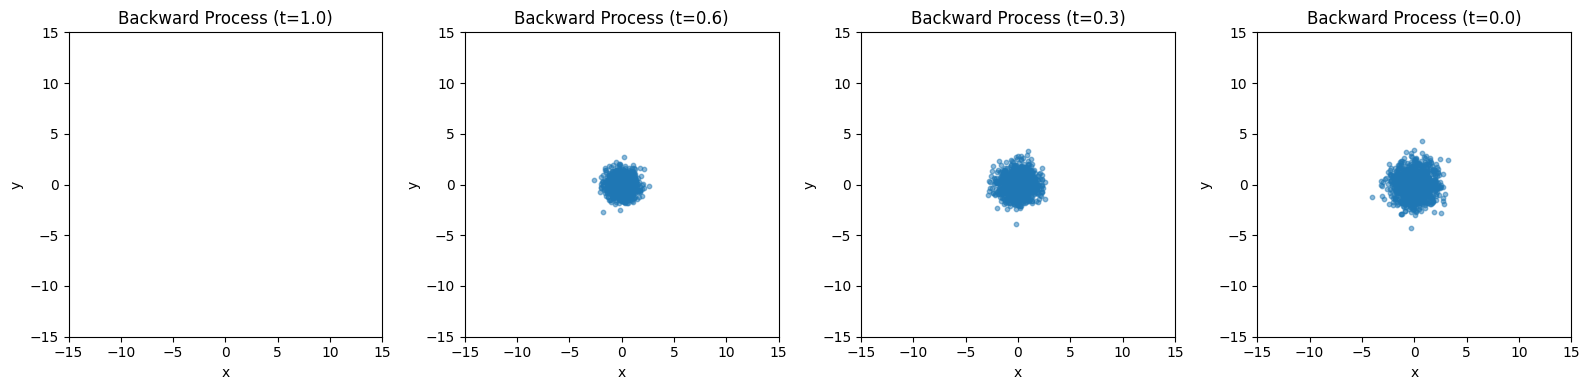

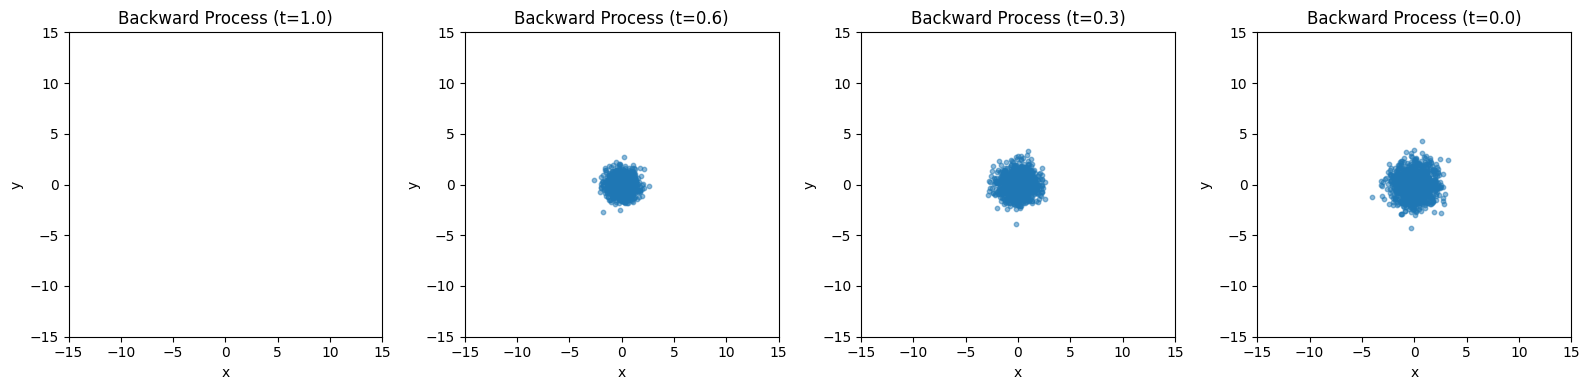

In [8]:
vis.plot_backward_process(score_model=trainer.trained_score,num_samples=1000, timesteps=[1.0, 0.6, 0.3, 0.0], num_timesteps=300, sigma=2.0, dim=2, bounds=(-15, 15))

In [71]:
# Let's see if it works for Gaussian mixture
test_data2=sample_gaussian_mixture_2d(N_samples=1000, n_modes=5, std=1.0, scale=10.0, x_offset=0.0, seed=123, symmetric=True)
test_data2=test_data2.to(dtype=torch.float32)

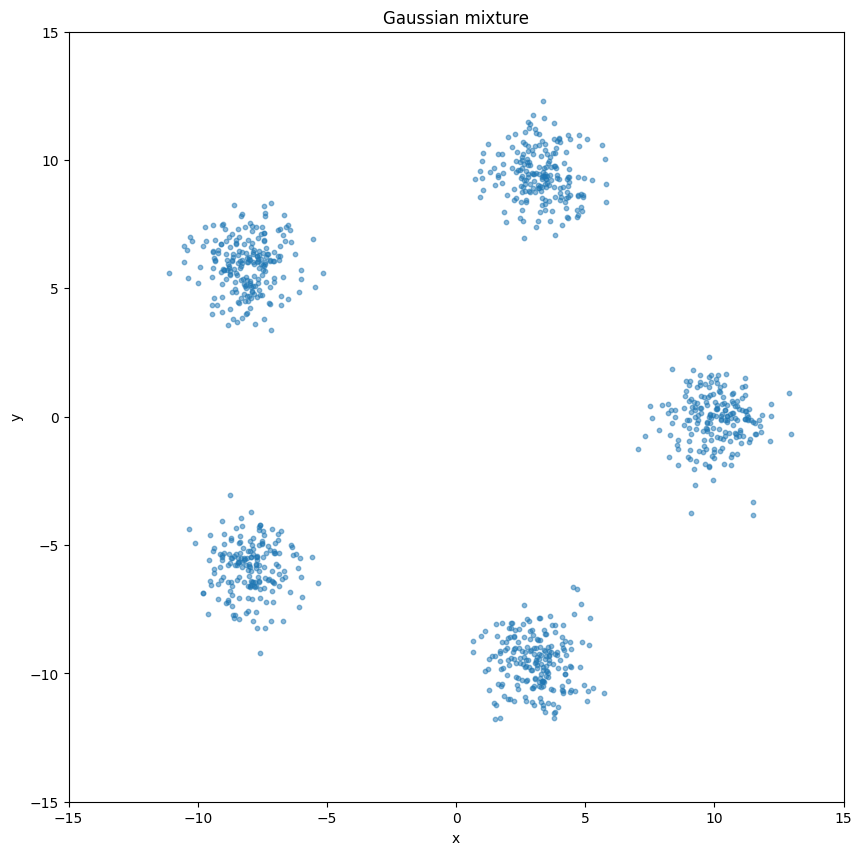

In [72]:
fig2,ax2=plt.subplots(figsize=(10,10))
vis.sample_inspection(test_data2, ax=ax2, title="Gaussian mixture", xlabel='x', ylabel='y')
plt.show()

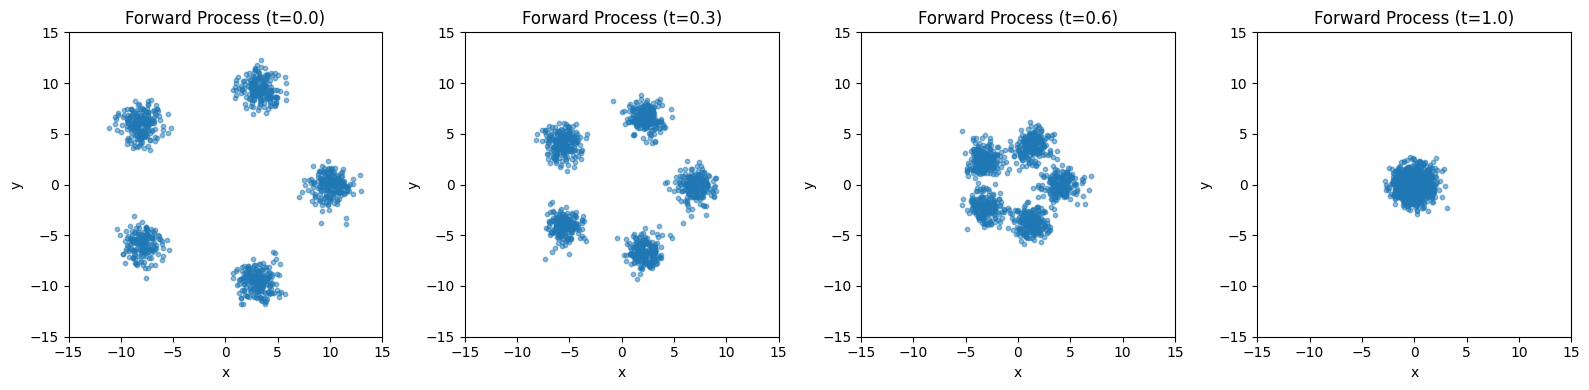

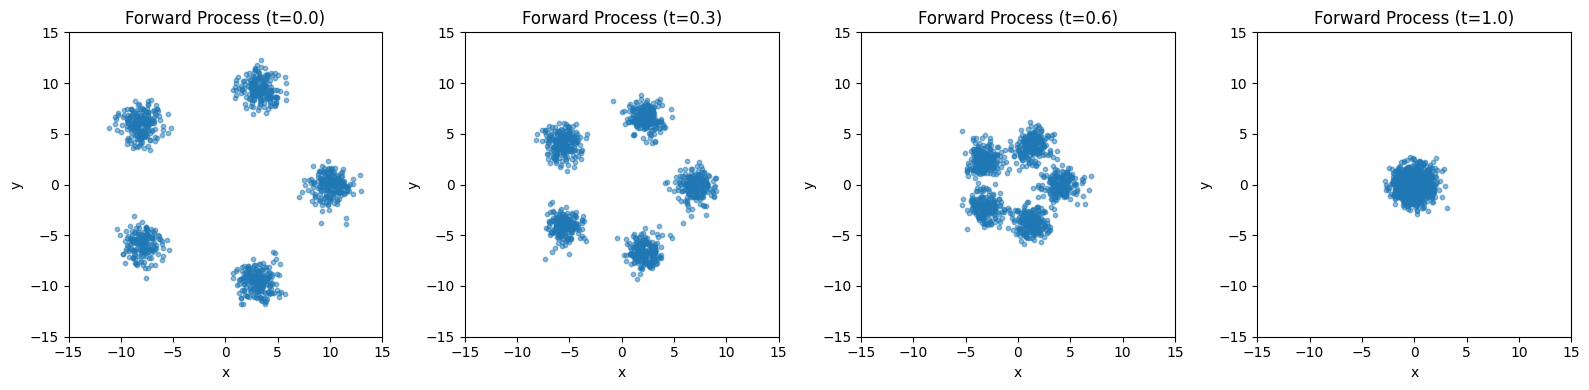

In [73]:
forward_model2=ForwardSDE(dim=2)
vis.plot_forward_process(forward_model2,test_data2,timesteps=[0.0, 0.3, 0.6, 1.0],bounds=(-15, 15))

In [74]:
# define the trainer
trainer2 = Trainer(sde=forward_model2, score_model=ApproxScore(dim=2, hiddens=[64, 64, 64, 64]))

In [76]:
trainer2.train(x_0=test_data2, num_epochs=100, lr=1e-3)

Training: 100%|██████████| 100/100 [00:00<00:00, 651.52it/s]

Epoch 1/100, Loss: 1.5771
Epoch 2/100, Loss: 1.5489
Epoch 3/100, Loss: 1.5936
Epoch 4/100, Loss: 1.4415
Epoch 5/100, Loss: 1.6075
Epoch 6/100, Loss: 1.5114
Epoch 7/100, Loss: 1.5620
Epoch 8/100, Loss: 1.5818
Epoch 9/100, Loss: 1.4968
Epoch 10/100, Loss: 1.5374
Epoch 11/100, Loss: 1.5210
Epoch 12/100, Loss: 1.5284
Epoch 13/100, Loss: 1.5893
Epoch 14/100, Loss: 1.4624
Epoch 15/100, Loss: 1.5640
Epoch 16/100, Loss: 1.7091
Epoch 17/100, Loss: 1.7117
Epoch 18/100, Loss: 1.6547
Epoch 19/100, Loss: 1.6683
Epoch 20/100, Loss: 1.6301
Epoch 21/100, Loss: 1.6990
Epoch 22/100, Loss: 1.5170
Epoch 23/100, Loss: 1.7782
Epoch 24/100, Loss: 1.5950
Epoch 25/100, Loss: 1.5289
Epoch 26/100, Loss: 1.6807
Epoch 27/100, Loss: 1.6052
Epoch 28/100, Loss: 1.5466
Epoch 29/100, Loss: 1.5836
Epoch 30/100, Loss: 1.6154
Epoch 31/100, Loss: 1.6809
Epoch 32/100, Loss: 1.4378
Epoch 33/100, Loss: 1.5746
Epoch 34/100, Loss: 1.5445
Epoch 35/100, Loss: 1.6198
Epoch 36/100, Loss: 1.5070
Epoch 37/100, Loss: 1.4530
Epoch 38/1

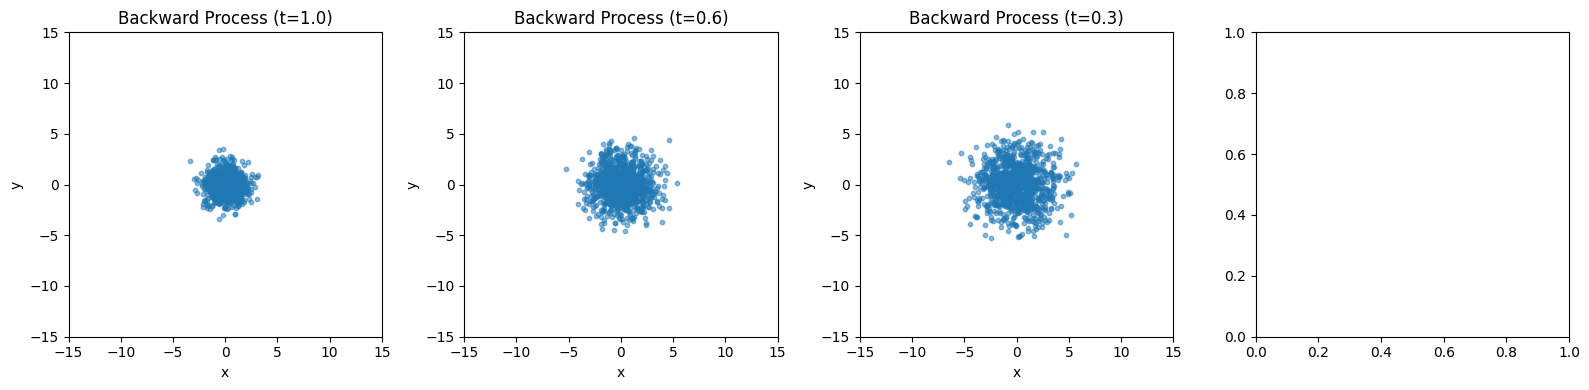

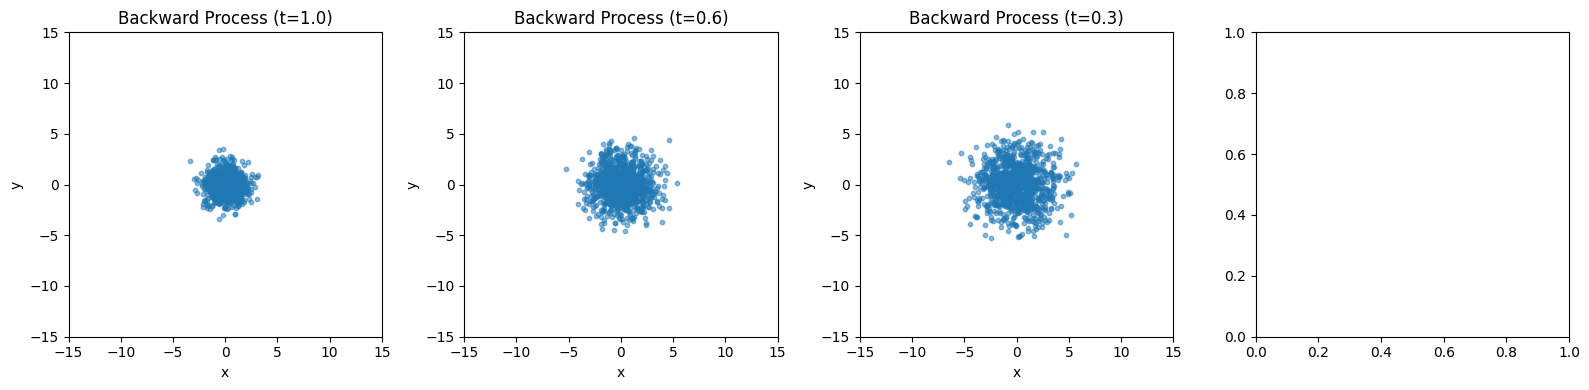

In [77]:
vis.plot_backward_process(score_model=trainer2.score_model,num_samples=1000, timesteps=[1.0, 0.6, 0.3, 0.0], num_timesteps=300, sigma=2.0, dim=2, bounds=(-15, 15))